# GameTheory-7-ExtensiveForm

**Navigation** : [<< 6-EvolutionTrust](GameTheory-6-EvolutionTrust.ipynb) | [Index](README.md) | [8-CombinatorialGames >>](GameTheory-8-CombinatorialGames.ipynb)

## Jeux sous Forme Extensive : Arbres de Jeu et Ensembles d'Information

Ce notebook introduit les **jeux sous forme extensive**, qui modelisent les situations strategiques dynamiques ou les joueurs agissent sequentiellement.

### Objectifs

1. Comprendre la representation en arbre des jeux dynamiques
2. Distinguer information parfaite et imparfaite
3. Manipuler les ensembles d'information (infosets)
4. Convertir entre formes normale et extensive
5. Utiliser OpenSpiel pour les jeux extensifs

### Prerequis

- Notebooks 1-6 (fondations, jeux matriciels)
- Notions de base sur les arbres et graphes

In [1]:
# Configuration et imports
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple, Any, Set
from collections import defaultdict
import networkx as nx

# OpenSpiel (optionnel)
try:
    import pyspiel
    HAS_OPENSPIEL = True
    print(f"OpenSpiel disponible, version: {pyspiel.__version__ if hasattr(pyspiel, '__version__') else 'N/A'}")
except ImportError:
    HAS_OPENSPIEL = False
    print("OpenSpiel non disponible - exemples avec implementation locale")

# Style matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

OpenSpiel disponible, version: 1.6.11


## 1. De la Forme Normale a la Forme Extensive

### 1.1 Limitations de la forme normale

La forme normale (matrice de gains) ne capture pas :
- **L'ordre des coups** : qui joue quand ?
- **L'information disponible** : que sait chaque joueur au moment de jouer ?
- **L'historique du jeu** : les actions precedentes

### 1.2 Elements d'un jeu extensif

Un jeu sous forme extensive comprend :

| Element | Description |
|---------|-------------|
| **Noeuds** | Points de decision ou le jeu peut se trouver |
| **Racine** | Noeud de depart du jeu |
| **Terminaux** | Noeuds finaux avec gains |
| **Actions** | Transitions entre noeuds |
| **Joueurs** | Incluant potentiellement "Nature" (hasard) |
| **Information sets** | Ensembles de noeuds indistinguables pour un joueur |

In [2]:
# Classes de base pour les jeux extensifs

@dataclass
class GameNode:
    """Noeud dans un arbre de jeu."""
    node_id: str
    player: int  # -1 pour terminal, 0 pour nature
    actions: List[str] = field(default_factory=list)
    children: Dict[str, 'GameNode'] = field(default_factory=dict)
    payoffs: Optional[Tuple[float, ...]] = None  # Pour noeuds terminaux
    infoset: Optional[str] = None  # Identifiant de l'ensemble d'information
    chance_probs: Optional[Dict[str, float]] = None  # Pour noeuds de nature
    
    def is_terminal(self) -> bool:
        return self.player == -1
    
    def is_chance(self) -> bool:
        return self.player == 0


class ExtensiveFormGame:
    """Jeu sous forme extensive."""
    
    def __init__(self, name: str, num_players: int):
        self.name = name
        self.num_players = num_players
        self.root: Optional[GameNode] = None
        self.nodes: Dict[str, GameNode] = {}
        self.infosets: Dict[str, List[str]] = defaultdict(list)  # infoset_id -> [node_ids]
    
    def add_node(self, node: GameNode):
        """Ajoute un noeud au jeu."""
        self.nodes[node.node_id] = node
        if node.infoset:
            self.infosets[node.infoset].append(node.node_id)
    
    def set_root(self, node: GameNode):
        """Definit le noeud racine."""
        self.root = node
        self.add_node(node)
    
    def get_terminal_nodes(self) -> List[GameNode]:
        """Retourne tous les noeuds terminaux."""
        return [n for n in self.nodes.values() if n.is_terminal()]
    
    def get_infoset_nodes(self, infoset_id: str) -> List[GameNode]:
        """Retourne les noeuds d'un ensemble d'information."""
        return [self.nodes[nid] for nid in self.infosets[infoset_id]]

## 2. Exemple : Jeu d'Entree sur le Marche

Un exemple classique de jeu sequentiel :

1. **Entrant** decide : Entrer (E) ou Rester dehors (O)
2. Si Entrer, **Incumbant** decide : Combattre (F) ou Accommoder (A)

```
                    Entrant
                   /       \
               E  /         \  O
                 /           \
           Incumbant        (0, 2)
            /     \
        F  /       \  A
          /         \
      (-1, -1)     (1, 1)
```

Gains : (Entrant, Incumbant)

In [3]:
def create_entry_game() -> ExtensiveFormGame:
    """Cree le jeu d'entree sur le marche."""
    game = ExtensiveFormGame("Entry Game", num_players=2)
    
    # Noeuds terminaux
    out_terminal = GameNode("out", player=-1, payoffs=(0, 2))
    fight_terminal = GameNode("fight", player=-1, payoffs=(-1, -1))
    accommodate_terminal = GameNode("accommodate", player=-1, payoffs=(1, 1))
    
    # Noeud de l'incumbant (joueur 2)
    incumbent_node = GameNode(
        "incumbent_choice",
        player=2,
        actions=["Fight", "Accommodate"],
        infoset="I2_1"
    )
    incumbent_node.children = {
        "Fight": fight_terminal,
        "Accommodate": accommodate_terminal
    }
    
    # Noeud racine (entrant, joueur 1)
    entrant_node = GameNode(
        "root",
        player=1,
        actions=["Enter", "Out"],
        infoset="I1_1"
    )
    entrant_node.children = {
        "Enter": incumbent_node,
        "Out": out_terminal
    }
    
    # Construire le jeu
    game.set_root(entrant_node)
    for node in [incumbent_node, out_terminal, fight_terminal, accommodate_terminal]:
        game.add_node(node)
    
    return game

entry_game = create_entry_game()
print(f"Jeu: {entry_game.name}")
print(f"Nombre de joueurs: {entry_game.num_players}")
print(f"Noeuds terminaux: {len(entry_game.get_terminal_nodes())}")

Jeu: Entry Game
Nombre de joueurs: 2
Noeuds terminaux: 3


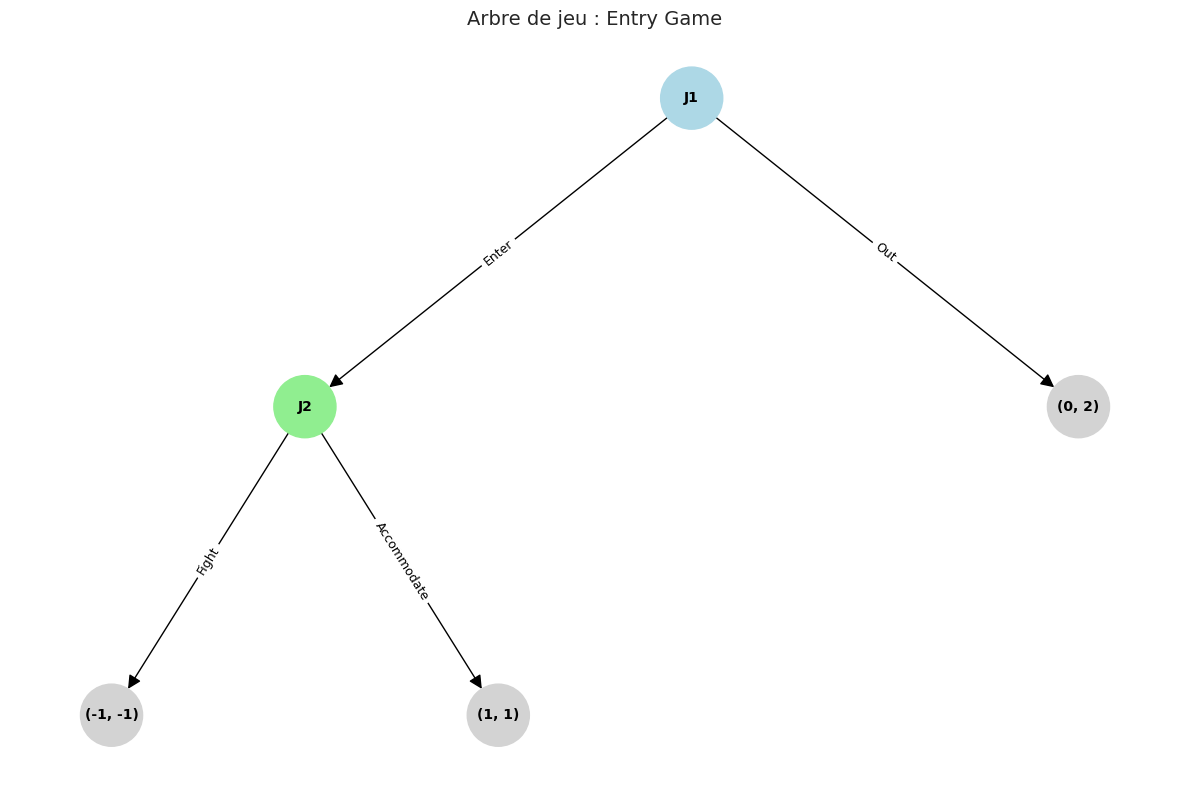

In [4]:
def visualize_game_tree(game: ExtensiveFormGame, figsize=(12, 8)):
    """Visualise l'arbre de jeu avec NetworkX."""
    G = nx.DiGraph()
    pos = {}
    labels = {}
    edge_labels = {}
    colors = []
    
    # Couleurs par joueur
    player_colors = {-1: 'lightgray', 0: 'lightyellow', 1: 'lightblue', 2: 'lightgreen'}
    
    def add_node_recursive(node, x=0, y=0, dx=2):
        G.add_node(node.node_id)
        pos[node.node_id] = (x, y)
        
        if node.is_terminal():
            labels[node.node_id] = f"{node.payoffs}"
        elif node.is_chance():
            labels[node.node_id] = "Nature"
        else:
            labels[node.node_id] = f"J{node.player}"
        
        colors.append(player_colors.get(node.player, 'white'))
        
        if node.children:
            n_children = len(node.children)
            x_start = x - (n_children - 1) * dx / 2
            for i, (action, child) in enumerate(node.children.items()):
                child_x = x_start + i * dx
                G.add_edge(node.node_id, child.node_id)
                edge_labels[(node.node_id, child.node_id)] = action
                add_node_recursive(child, child_x, y - 1, dx / 2)
    
    add_node_recursive(game.root)
    
    # Tracer
    fig, ax = plt.subplots(figsize=figsize)
    nx.draw(G, pos, ax=ax, labels=labels, node_color=colors,
            node_size=2000, font_size=10, font_weight='bold',
            arrows=True, arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=9)
    
    ax.set_title(f"Arbre de jeu : {game.name}", fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_game_tree(entry_game)

## 3. Strategies dans les Jeux Extensifs

### 3.1 Strategie Pure

Une **strategie pure** est un plan d'action complet : elle specifie une action pour **chaque ensemble d'information** du joueur.

Pour l'Entrant : 2 strategies (Enter ou Out)  
Pour l'Incumbant : 2 strategies (Fight ou Accommodate)

### 3.2 Strategie Comportementale

Une **strategie comportementale** associe une distribution de probabilite sur les actions a chaque ensemble d'information.

### 3.3 Equivalence (Theoreme de Kuhn)

Dans les jeux avec **rappel parfait** (chaque joueur se souvient de toutes ses actions passees), strategies mixtes et comportementales sont equivalentes.

In [5]:
@dataclass
class PureStrategy:
    """Strategie pure pour un joueur."""
    player: int
    actions: Dict[str, str]  # infoset_id -> action
    
    def get_action(self, infoset: str) -> str:
        return self.actions.get(infoset, None)


@dataclass 
class BehavioralStrategy:
    """Strategie comportementale pour un joueur."""
    player: int
    probabilities: Dict[str, Dict[str, float]]  # infoset -> {action -> prob}
    
    def get_action_prob(self, infoset: str, action: str) -> float:
        if infoset not in self.probabilities:
            return 0.0
        return self.probabilities[infoset].get(action, 0.0)
    
    def sample_action(self, infoset: str) -> str:
        """Echantillonne une action selon la distribution."""
        probs = self.probabilities[infoset]
        actions = list(probs.keys())
        weights = [probs[a] for a in actions]
        return np.random.choice(actions, p=weights)


# Strategies pour le jeu d'entree
print("Strategies pures pour l'Entrant:")
entrant_enter = PureStrategy(1, {"I1_1": "Enter"})
entrant_out = PureStrategy(1, {"I1_1": "Out"})
print(f"  - S1: {entrant_enter.actions}")
print(f"  - S2: {entrant_out.actions}")

print("\nStrategies pures pour l'Incumbant:")
incumbent_fight = PureStrategy(2, {"I2_1": "Fight"})
incumbent_acc = PureStrategy(2, {"I2_1": "Accommodate"})
print(f"  - S1: {incumbent_fight.actions}")
print(f"  - S2: {incumbent_acc.actions}")

Strategies pures pour l'Entrant:
  - S1: {'I1_1': 'Enter'}
  - S2: {'I1_1': 'Out'}

Strategies pures pour l'Incumbant:
  - S1: {'I2_1': 'Fight'}
  - S2: {'I2_1': 'Accommodate'}


In [6]:
def evaluate_strategy_profile(game: ExtensiveFormGame, 
                               strategies: Dict[int, PureStrategy]) -> Tuple[float, ...]:
    """
    Evalue un profil de strategies pures.
    
    Args:
        game: Le jeu extensif
        strategies: Dict {player -> PureStrategy}
    
    Returns:
        Tuple des gains pour chaque joueur
    """
    def traverse(node: GameNode) -> Tuple[float, ...]:
        if node.is_terminal():
            return node.payoffs
        
        if node.is_chance():
            # Moyenne ponderee pour les noeuds de nature
            expected = np.zeros(game.num_players)
            for action, prob in node.chance_probs.items():
                child_payoffs = traverse(node.children[action])
                expected += prob * np.array(child_payoffs)
            return tuple(expected)
        
        # Noeud de decision
        strategy = strategies[node.player]
        action = strategy.get_action(node.infoset)
        return traverse(node.children[action])
    
    return traverse(game.root)


# Tester tous les profils de strategies
print("Matrice de gains du jeu d'entree:")
print("\n              Fight    Accommodate")
for e_strat, e_name in [(entrant_enter, "Enter"), (entrant_out, "Out")]:
    row = f"{e_name:8}  "
    for i_strat in [incumbent_fight, incumbent_acc]:
        payoffs = evaluate_strategy_profile(entry_game, {1: e_strat, 2: i_strat})
        row += f"  {payoffs}    "
    print(row)

Matrice de gains du jeu d'entree:

              Fight    Accommodate
Enter       (-1, -1)      (1, 1)    
Out         (0, 2)      (0, 2)    


### Forme normale du jeu d'entree : analyse

La matrice ci-dessus revele la structure strategique du jeu :

**Observations cles** :
- La strategie "Out" de l'entrant donne **(0, 2)** quelle que soit la strategie de l'incumbant
- Cela signifie que la "menace" de Fight n'affecte pas le gain si l'entrant reste dehors
- Pourtant, cette menace peut influencer la decision d'entrer !

**Equilibres de Nash (forme normale)** :
1. **(Enter, Accommodate)** : Gains (1, 1)
2. **(Out, Fight)** : Gains (0, 2)

**Le probleme** : Le deuxieme equilibre repose sur une menace **non credible**. L'incumbant ne combattrait jamais reellement (car -1 < 1).

C'est exactement pourquoi la forme extensive est importante : elle nous permet de detecter ces menaces vides en analysant les sous-jeux (voir notebook 9).

## 4. Information Parfaite vs Imparfaite

### 4.1 Information Parfaite

Un jeu a **information parfaite** si chaque ensemble d'information contient **exactement un noeud**. Chaque joueur connait l'historique complet du jeu.

Exemples : Echecs, Morpion, Go, Jeu d'entree

### 4.2 Information Imparfaite

Un jeu a **information imparfaite** si certains ensembles d'information contiennent **plusieurs noeuds**. Le joueur ne peut pas distinguer ces noeuds.

Exemples : Poker, Bataille navale, jeux avec coups simultanes

In [7]:
def create_simultaneous_move_game() -> ExtensiveFormGame:
    """
    Cree un jeu de coups simultanes (Matching Pennies) 
    represente sous forme extensive avec information imparfaite.
    
    J1 choisit H ou T
    J2 choisit H ou T sans voir le choix de J1
    -> Les noeuds de decision de J2 sont dans le meme infoset
    """
    game = ExtensiveFormGame("Matching Pennies (Extensive)", num_players=2)
    
    # Noeuds terminaux
    hh = GameNode("HH", player=-1, payoffs=(1, -1))   # Match: J1 gagne
    ht = GameNode("HT", player=-1, payoffs=(-1, 1))  # No match: J2 gagne
    th = GameNode("TH", player=-1, payoffs=(-1, 1))  # No match: J2 gagne
    tt = GameNode("TT", player=-1, payoffs=(1, -1))   # Match: J1 gagne
    
    # Noeuds de J2 - MEME INFOSET (information imparfaite)
    j2_after_h = GameNode("J2_afterH", player=2, actions=["H", "T"], infoset="I2")
    j2_after_h.children = {"H": hh, "T": ht}
    
    j2_after_t = GameNode("J2_afterT", player=2, actions=["H", "T"], infoset="I2")  # MEME infoset!
    j2_after_t.children = {"H": th, "T": tt}
    
    # Noeud de J1 (racine)
    j1_node = GameNode("root", player=1, actions=["H", "T"], infoset="I1")
    j1_node.children = {"H": j2_after_h, "T": j2_after_t}
    
    game.set_root(j1_node)
    for node in [j2_after_h, j2_after_t, hh, ht, th, tt]:
        game.add_node(node)
    
    return game

mp_game = create_simultaneous_move_game()

print("Jeu des Pennies (Matching Pennies) - Information Imparfaite")
print("="*60)
print(f"\nInfoset de J2: {mp_game.infosets['I2']}")
print("-> J2 ne sait pas si J1 a joue H ou T!")

# Verification: l'information parfaite implique singletons
def has_perfect_information(game: ExtensiveFormGame) -> bool:
    """Verifie si le jeu a information parfaite."""
    for infoset_id, nodes in game.infosets.items():
        if len(nodes) > 1:
            return False
    return True

print(f"\nJeu d'entree - Information parfaite: {has_perfect_information(entry_game)}")
print(f"Matching Pennies - Information parfaite: {has_perfect_information(mp_game)}")

Jeu des Pennies (Matching Pennies) - Information Imparfaite

Infoset de J2: ['J2_afterH', 'J2_afterT']
-> J2 ne sait pas si J1 a joue H ou T!

Jeu d'entree - Information parfaite: True
Matching Pennies - Information parfaite: False


### L'importance des infosets

La visualisation ci-dessus montre pourquoi les **ensembles d'information** sont centraux en theorie des jeux :

**Matching Pennies comme jeu simultane** :
- Meme si J1 "joue en premier" dans l'arbre, J2 ne sait pas ce que J1 a joue
- Les deux noeuds de J2 sont dans le **meme infoset** (ellipse rouge)
- Cela rend le jeu **strategiquement equivalent** a un jeu simultane

**Consequences pratiques** :
1. J2 ne peut pas conditionner sa strategie sur l'action de J1
2. La seule strategie possible pour J2 est "jouer H" ou "jouer T" (pas "si J1 joue H alors...")
3. C'est exactement comme si les deux joueurs choisissaient en meme temps

**Le lien avec le poker** :
- Au poker, vous ne voyez pas les cartes des autres
- Vous ne savez pas s'ils ont une bonne ou mauvaise main
- Tous les etats ou ils ont une bonne main sont dans le meme infoset depuis votre perspective
- Votre strategie doit etre la meme pour tous ces etats !

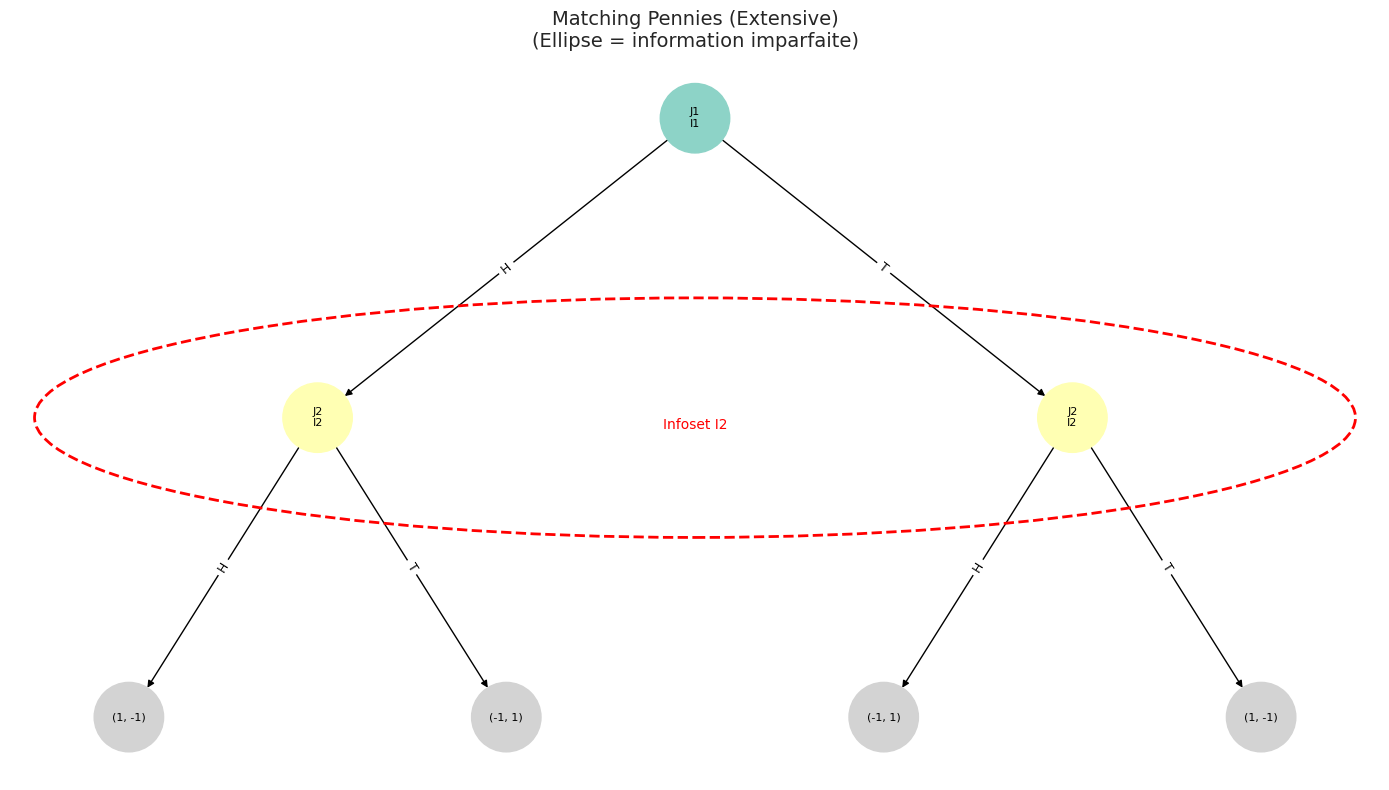

In [8]:
def visualize_with_infosets(game: ExtensiveFormGame, figsize=(14, 8)):
    """Visualise l'arbre avec les infosets en surbrillance."""
    G = nx.DiGraph()
    pos = {}
    labels = {}
    edge_labels = {}
    
    # Couleurs pour infosets (cycling)
    infoset_colors = plt.cm.Set3(np.linspace(0, 1, 12))
    infoset_to_color = {}
    color_idx = 0
    
    def get_node_color(node):
        nonlocal color_idx
        if node.is_terminal():
            return 'lightgray'
        if node.infoset:
            if node.infoset not in infoset_to_color:
                infoset_to_color[node.infoset] = infoset_colors[color_idx % 12]
                color_idx += 1
            return infoset_to_color[node.infoset]
        return 'white'
    
    colors = []
    
    def add_nodes(node, x=0, y=0, dx=2):
        G.add_node(node.node_id)
        pos[node.node_id] = (x, y)
        colors.append(get_node_color(node))
        
        if node.is_terminal():
            labels[node.node_id] = f"{node.payoffs}"
        else:
            labels[node.node_id] = f"J{node.player}\n{node.infoset}"
        
        if node.children:
            n = len(node.children)
            x_start = x - (n-1) * dx / 2
            for i, (action, child) in enumerate(node.children.items()):
                G.add_edge(node.node_id, child.node_id)
                edge_labels[(node.node_id, child.node_id)] = action
                add_nodes(child, x_start + i*dx, y-1, dx/2)
    
    add_nodes(game.root)
    
    fig, ax = plt.subplots(figsize=figsize)
    nx.draw(G, pos, ax=ax, labels=labels, node_color=colors,
            node_size=2500, font_size=8, arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=9)
    
    # Dessiner les ellipses autour des infosets multiples
    for infoset_id, node_ids in game.infosets.items():
        if len(node_ids) > 1:
            positions = [pos[nid] for nid in node_ids]
            xs, ys = zip(*positions)
            center = (np.mean(xs), np.mean(ys))
            width = max(xs) - min(xs) + 1.5
            height = max(ys) - min(ys) + 0.8
            ellipse = plt.matplotlib.patches.Ellipse(
                center, width, height, fill=False, 
                linestyle='--', linewidth=2, edgecolor='red'
            )
            ax.add_patch(ellipse)
            ax.annotate(f"Infoset {infoset_id}", center, fontsize=10, 
                       color='red', ha='center', va='top')
    
    ax.set_title(f"{game.name}\n(Ellipse = information imparfaite)", fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_with_infosets(mp_game)

## 5. Jeux avec Hasard : Noeuds de Nature

Certains jeux incluent des elements aleatoires : tirage de cartes, lancers de des, etc.

On modelise cela par un joueur special appele **Nature** (joueur 0) qui "choisit" selon des probabilites connues.

In [9]:
def create_simple_card_game() -> ExtensiveFormGame:
    """
    Jeu de carte simple:
    1. Nature tire une carte (H=high avec p=0.5, L=low avec p=0.5)
    2. J1 voit la carte et decide: Bet ou Check
    3. Si Bet, J2 decide: Call ou Fold (sans voir la carte)
    
    Gains (simplifies):
    - Check: (1,1) si H, (-1,-1) si L
    - Bet+Fold: (1, -1)
    - Bet+Call: (2, -2) si H, (-2, 2) si L
    """
    game = ExtensiveFormGame("Simple Card Game", num_players=2)
    
    # Terminaux pour H (high card)
    h_check = GameNode("H_check", -1, payoffs=(1, 1))
    h_fold = GameNode("H_fold", -1, payoffs=(1, -1))
    h_call = GameNode("H_call", -1, payoffs=(2, -2))
    
    # Terminaux pour L (low card)
    l_check = GameNode("L_check", -1, payoffs=(-1, -1))
    l_fold = GameNode("L_fold", -1, payoffs=(1, -1))
    l_call = GameNode("L_call", -1, payoffs=(-2, 2))
    
    # J2 apres Bet (ne sait pas si H ou L) - MEME INFOSET
    j2_after_h_bet = GameNode("J2_H_bet", 2, ["Call", "Fold"], infoset="I2_bet")
    j2_after_h_bet.children = {"Call": h_call, "Fold": h_fold}
    
    j2_after_l_bet = GameNode("J2_L_bet", 2, ["Call", "Fold"], infoset="I2_bet")  # MEME infoset
    j2_after_l_bet.children = {"Call": l_call, "Fold": l_fold}
    
    # J1 avec carte H - infoset separe car il voit la carte
    j1_with_h = GameNode("J1_H", 1, ["Bet", "Check"], infoset="I1_H")
    j1_with_h.children = {"Bet": j2_after_h_bet, "Check": h_check}
    
    # J1 avec carte L - infoset separe
    j1_with_l = GameNode("J1_L", 1, ["Bet", "Check"], infoset="I1_L")
    j1_with_l.children = {"Bet": j2_after_l_bet, "Check": l_check}
    
    # Noeud de Nature (racine)
    nature = GameNode("nature", 0, ["H", "L"])
    nature.children = {"H": j1_with_h, "L": j1_with_l}
    nature.chance_probs = {"H": 0.5, "L": 0.5}
    
    game.set_root(nature)
    for node in [j1_with_h, j1_with_l, j2_after_h_bet, j2_after_l_bet,
                 h_check, h_fold, h_call, l_check, l_fold, l_call]:
        game.add_node(node)
    
    return game

card_game = create_simple_card_game()
print("Jeu de cartes simple")
print("="*50)
print(f"Infosets de J1: I1_H (carte haute), I1_L (carte basse)")
print(f"Infosets de J2: {card_game.infosets['I2_bet']} (ne connait pas la carte)")

Jeu de cartes simple
Infosets de J1: I1_H (carte haute), I1_L (carte basse)
Infosets de J2: ['J2_H_bet', 'J2_L_bet'] (ne connait pas la carte)


## 6. OpenSpiel : Jeux Extensifs Avances

OpenSpiel fournit de nombreux jeux deja implementes avec une API standardisee.

In [10]:
if HAS_OPENSPIEL:
    # Kuhn Poker - jeu classique a information imparfaite
    kuhn = pyspiel.load_game("kuhn_poker")
    
    print("Kuhn Poker (OpenSpiel)")
    print("="*50)
    print(f"Nombre de joueurs: {kuhn.num_players()}")
    print(f"Type de jeu: {kuhn.get_type().dynamics}")
    print(f"Information: {kuhn.get_type().information}")
    print(f"Utilite: {kuhn.get_type().utility}")
    
    # Simuler une partie
    state = kuhn.new_initial_state()
    print(f"\nEtat initial: {state}")
    
    # Historique d'une partie exemple
    print("\nSimulation d'une partie:")
    while not state.is_terminal():
        if state.is_chance_node():
            outcomes = state.chance_outcomes()
            action, prob = outcomes[np.random.choice(len(outcomes))]
            print(f"  Nature tire: action {action} (p={prob:.2f})")
        else:
            player = state.current_player()
            actions = state.legal_actions()
            action = np.random.choice(actions)
            print(f"  Joueur {player} joue: {state.action_to_string(player, action)}")
        
        state.apply_action(action)
    
    print(f"\nResultat: {state.returns()}")
else:
    print("OpenSpiel non disponible")
    print("Pour installer: pip install open_spiel")

Kuhn Poker (OpenSpiel)
Nombre de joueurs: 2
Type de jeu: Dynamics.SEQUENTIAL
Information: Information.IMPERFECT_INFORMATION
Utilite: Utility.ZERO_SUM

Etat initial: 

Simulation d'une partie:
  Nature tire: action 0 (p=0.33)
  Nature tire: action 2 (p=0.50)
  Joueur 0 joue: Bet
  Joueur 1 joue: Pass

Resultat: [1.0, -1.0]


In [11]:
if HAS_OPENSPIEL:
    def explore_game_tree(game, max_nodes=20):
        """Explore l'arbre de jeu d'OpenSpiel."""
        state = game.new_initial_state()
        nodes_visited = 0
        
        def dfs(state, depth=0):
            nonlocal nodes_visited
            if nodes_visited >= max_nodes:
                return
            
            indent = "  " * depth
            nodes_visited += 1
            
            if state.is_terminal():
                print(f"{indent}[Terminal] Gains: {state.returns()}")
                return
            
            if state.is_chance_node():
                print(f"{indent}[Nature] Outcomes: {len(state.chance_outcomes())}")
                for action, prob in state.chance_outcomes()[:2]:  # Limiter
                    child = state.child(action)
                    print(f"{indent}  -> action {action} (p={prob:.2f})")
                    dfs(child, depth + 1)
            else:
                player = state.current_player()
                infoset = state.information_state_string(player)
                print(f"{indent}[J{player}] Infoset: {infoset[:30]}...")
                for action in state.legal_actions()[:2]:  # Limiter
                    child = state.child(action)
                    print(f"{indent}  -> {state.action_to_string(player, action)}")
                    dfs(child, depth + 1)
        
        print(f"\nExploration de l'arbre de {game.get_type().short_name}:")
        print("="*50)
        dfs(state)
    
    explore_game_tree(kuhn)


Exploration de l'arbre de kuhn_poker:
[Nature] Outcomes: 3
  -> action 0 (p=0.33)
  [Nature] Outcomes: 2
    -> action 1 (p=0.50)
    [J0] Infoset: 0...
      -> Pass
      [J1] Infoset: 1p...
        -> Pass
        [Terminal] Gains: [-1.0, 1.0]
        -> Bet
        [J0] Infoset: 0pb...
          -> Pass
          [Terminal] Gains: [-1.0, 1.0]
          -> Bet
          [Terminal] Gains: [-2.0, 2.0]
      -> Bet
      [J1] Infoset: 1b...
        -> Pass
        [Terminal] Gains: [1.0, -1.0]
        -> Bet
        [Terminal] Gains: [-2.0, 2.0]
    -> action 2 (p=0.50)
    [J0] Infoset: 0...
      -> Pass
      [J1] Infoset: 2p...
        -> Pass
        [Terminal] Gains: [-1.0, 1.0]
        -> Bet
        [J0] Infoset: 0pb...
          -> Pass
          [Terminal] Gains: [-1.0, 1.0]
          -> Bet
          [Terminal] Gains: [-2.0, 2.0]
      -> Bet
      [J1] Infoset: 2b...
        -> Pass
        [Terminal] Gains: [1.0, -1.0]
        -> Bet
        [Terminal] Gains: [-2.0, 2.0]


## 7. Conversion Forme Extensive -> Forme Normale

Tout jeu extensif peut etre converti en forme normale en enumerant toutes les strategies pures.

**Attention** : La taille de la matrice peut exploser exponentiellement!

In [12]:
from itertools import product

def extensive_to_normal(game: ExtensiveFormGame):
    """
    Convertit un jeu extensif en forme normale.
    
    Returns:
        Dict avec matrices de gains et labels de strategies
    """
    # Collecter les infosets par joueur
    player_infosets = defaultdict(list)
    infoset_actions = {}
    
    for node in game.nodes.values():
        if node.infoset and not node.is_terminal() and not node.is_chance():
            if node.infoset not in infoset_actions:
                player_infosets[node.player].append(node.infoset)
                infoset_actions[node.infoset] = node.actions
    
    # Generer toutes les strategies pures
    def generate_strategies(player):
        infosets = player_infosets[player]
        if not infosets:
            return [PureStrategy(player, {})]
        
        action_combinations = product(
            *[infoset_actions[i] for i in infosets]
        )
        
        strategies = []
        for combo in action_combinations:
            actions = dict(zip(infosets, combo))
            strategies.append(PureStrategy(player, actions))
        return strategies
    
    strategies_p1 = generate_strategies(1)
    strategies_p2 = generate_strategies(2)
    
    m, n = len(strategies_p1), len(strategies_p2)
    A = np.zeros((m, n))
    B = np.zeros((m, n))
    
    for i, s1 in enumerate(strategies_p1):
        for j, s2 in enumerate(strategies_p2):
            payoffs = evaluate_strategy_profile(game, {1: s1, 2: s2})
            A[i, j] = payoffs[0]
            B[i, j] = payoffs[1]
    
    return {
        'A': A,
        'B': B,
        'row_strategies': strategies_p1,
        'col_strategies': strategies_p2
    }


# Convertir le jeu d'entree
normal_form = extensive_to_normal(entry_game)

print("Jeu d'entree - Forme Normale")
print("="*50)
print(f"\nStrategies du joueur 1:")
for i, s in enumerate(normal_form['row_strategies']):
    print(f"  S{i+1}: {s.actions}")

print(f"\nStrategies du joueur 2:")
for j, s in enumerate(normal_form['col_strategies']):
    print(f"  S{j+1}: {s.actions}")

print(f"\nMatrice des gains (Joueur 1):")
print(normal_form['A'])
print(f"\nMatrice des gains (Joueur 2):")
print(normal_form['B'])

Jeu d'entree - Forme Normale

Strategies du joueur 1:
  S1: {'I1_1': 'Enter'}
  S2: {'I1_1': 'Out'}

Strategies du joueur 2:
  S1: {'I2_1': 'Fight'}
  S2: {'I2_1': 'Accommodate'}

Matrice des gains (Joueur 1):
[[-1.  1.]
 [ 0.  0.]]

Matrice des gains (Joueur 2):
[[-1.  1.]
 [ 2.  2.]]


## 8. Exercices

### Exercice 1 : Ultimatum

Dans le jeu de l'ultimatum :
1. J1 propose un partage x (sur 10 euros)
2. J2 accepte (gains: 10-x, x) ou refuse (gains: 0, 0)

Implementez ce jeu avec x dans {2, 4, 5, 6, 8}.

### Exercice 2 : Stackelberg simplifie

Duopole sequentiel :
1. Leader choisit quantite q1 dans {Low, High}
2. Follower observe q1 et choisit q2 dans {Low, High}

Construisez l'arbre et identifiez l'equilibre.

### Exercice 3 : Information

Modifiez le jeu de Stackelberg pour que le follower ne voie PAS q1. Comment change le jeu ?

In [13]:
# Espace pour vos solutions

# Exercice 1: Jeu de l'ultimatum
def create_ultimatum_game(offers=[2, 4, 5, 6, 8]):
    """Cree le jeu de l'ultimatum avec les offres specifiees."""
    game = ExtensiveFormGame("Ultimatum", num_players=2)
    
    # A completer...
    pass

# Exercice 2: Stackelberg
def create_stackelberg_game():
    """Cree le jeu de Stackelberg simplifie."""
    game = ExtensiveFormGame("Stackelberg", num_players=2)
    
    # A completer...
    pass

## 9. Resume

| Concept | Description |
|---------|-------------|
| **Forme extensive** | Representation en arbre des jeux dynamiques |
| **Noeud** | Point de decision (joueur, nature, terminal) |
| **Information set** | Ensemble de noeuds indistinguables pour un joueur |
| **Information parfaite** | Chaque infoset contient un seul noeud |
| **Information imparfaite** | Des infosets avec plusieurs noeuds |
| **Strategie pure** | Plan complet (une action par infoset) |
| **Strategie comportementale** | Distribution de probabilite par infoset |

### Points cles

- La forme extensive capture la **dynamique** du jeu
- Les infosets modelisent l'**incertitude strategique**
- La conversion extensive -> normale est **exponentielle**
- OpenSpiel fournit de nombreux jeux pre-implementes

### Prochaine etape

**Notebook 8 : Induction Arriere** - Resolution des jeux a information parfaite par raisonnement retrograde.